In [1]:
################# USUALLY PREINSTALLED IN COLAB #################
# !pip install numpy pandas sqlalchemy sqlglot
# !pip install torch transformers spacy

!pip install Levenshtein
!pip install accelerate
!pip install bitsandbytes
!pip install sentence-transformers
!pip install spacy-transformers

!python -m spacy download en_core_web_md
!python -m spacy download en_core_web_trf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.4/177.4 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.5/137.5 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.3/245.3 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.8/126.8 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 197.8/197.8 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.0/314.0 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 39.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 46.2 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.19.1
    Uninstalling tokenizers-0.19.1:
      Successfully uninstalled tokenizers-0.19.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.44.2
    Uninstalling transfor

In [1]:
import os
import numpy as np
import pandas as pd

Input data
We had previously downloaded the Young People Survey Dataset from Kaggle and loaded it into a sqlite DB. Let's take a look at the data once more.

In [2]:
df = pd.read_csv('/content/sample_data/young_people_survey.csv')
df.head()

,Music,Slow songs or fast songs,Dance,Folk,Country,Classical music,Musical,Pop,Rock,Metal or Hardrock,...,Age,Height,Weight,Number of siblings,Gender,Left - right handed,Education,Only child,Village - town,House - block of flats
0,5.0,3.0,2.0,1.0,2.0,2.0,1.0,5.0,5.0,1.0,...,20.0,163.0,48.0,1.0,female,right handed,college/bachelor degree,no,village,block of flats
1,4.0,4.0,2.0,1.0,1.0,1.0,2.0,3.0,5.0,4.0,...,19.0,163.0,58.0,2.0,female,right handed,college/bachelor degree,no,city,block of flats
2,5.0,5.0,2.0,2.0,3.0,4.0,5.0,3.0,5.0,3.0,...,20.0,176.0,67.0,2.0,female,right handed,secondary school,no,city,block of flats
3,5.0,3.0,2.0,1.0,1.0,1.0,1.0,2.0,2.0,1.0,...,22.0,172.0,59.0,1.0,female,right handed,college/bachelor degree,yes,city,house/bungalow
4,5.0,3.0,4.0,3.0,2.0,4.0,3.0,5.0,3.0,1.0,...,20.0,170.0,59.0,1.0,female,right handed,secondary school,no,village,house/bungalow


Checking the SQLite DB
Let's connect to our sqlite file and look at its contents

In [3]:
from sqlalchemy import create_engine
engine = create_engine(f"sqlite:///mysqlitedb.db")
table_name = 'young_people_survey'

try:
    df = pd.read_csv('/content/sample_data/young_people_survey.csv')
    df.to_sql(table_name, engine, index=False)
    print('Data loaded from CSV file!')
except ValueError as e:
    err_msg = e.args[0]
    if 'already exists' in err_msg:
        print('Table already exists in SQLite DB')

Data loaded from CSV file!


In [4]:
with engine.connect() as conn, conn.begin():
    sqlite_master = pd.read_sql_query("SELECT * FROM sqlite_master", conn)

sqlite_master

,type,name,tbl_name,rootpage,sql
0,table,young_people_survey,young_people_survey,2,"CREATE TABLE young_people_survey (\n\t""Music"" ..."


As before, we can get the table DDL from the sqlite_master table

In [5]:
sqlite_master['sql_fmt'] = sqlite_master['sql'].apply(lambda z: [x.strip().strip(',').rsplit(' ', maxsplit=1) for x in z.split('\n')[1:-1]])

table_desc_dict = {}
for _, row in sqlite_master.iterrows():
    table_desc_dict[row['name']] = row['sql']

schema = table_desc_dict[table_name]
print(schema)

CREATE TABLE young_people_survey (
	"Music" FLOAT, 
	"Slow songs or fast songs" FLOAT, 
	"Dance" FLOAT, 
	"Folk" FLOAT, 
	"Country" FLOAT, 
	"Classical music" FLOAT, 
	"Musical" FLOAT, 
	"Pop" FLOAT, 
	"Rock" FLOAT, 
	"Metal or Hardrock" FLOAT, 
	"Punk" FLOAT, 
	"Hiphop, Rap" FLOAT, 
	"Reggae, Ska" FLOAT, 
	"Swing, Jazz" FLOAT, 
	"Rock n roll" FLOAT, 
	"Alternative" FLOAT, 
	"Latino" FLOAT, 
	"Techno, Trance" FLOAT, 
	"Opera" FLOAT, 
	"Movies" FLOAT, 
	"Horror" FLOAT, 
	"Thriller" FLOAT, 
	"Comedy" FLOAT, 
	"Romantic" FLOAT, 
	"Sci-fi" FLOAT, 
	"War" FLOAT, 
	"Fantasy/Fairy tales" FLOAT, 
	"Animated" FLOAT, 
	"Documentary" FLOAT, 
	"Western" FLOAT, 
	"Action" FLOAT, 
	"History" FLOAT, 
	"Psychology" FLOAT, 
	"Politics" FLOAT, 
	"Mathematics" FLOAT, 
	"Physics" FLOAT, 
	"Internet" FLOAT, 
	"PC" FLOAT, 
	"Economy Management" FLOAT, 
	"Biology" FLOAT, 
	"Chemistry" FLOAT, 
	"Reading" FLOAT, 
	"Geography" FLOAT, 
	"Foreign languages" FLOAT, 
	"Medicine" FLOAT, 
	"Law" FLOAT, 
	"Cars" FLOAT

Why Preprocesses: LLM Prompt Pruning
Even though LLMs are offering longer context lengths every day, they still tend to get lost in the middle, i.e. the model pays most attention to the beginning and the end of the prompt. Since we are adding our table DDL in the prompt as context and DDLs can contain tables numbering in the multiples of hundreds, it is seen that the LLM often fails to "pick" the relevant column names, especially if they occur in the middle of the DDL.

To fix this, we "prune" the DDL, i.e. we do not include all the columns but only those which we deem relevant to our question. With this shortened DDL, the LLM should have a much easier time selecting the correct column and also leaves more room in the context window for the generated SQL.

To find the columns which are "relevant" to our question, we compute a similarity metric between the column names/descriptions and the question.

In [8]:
!pip install sentence_transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.3/245.3 kB 5.7 MB/s eta 0:00:00


In [9]:
import spacy
import torch
import sqlglot
import numpy as np
import os, re, logging, pickle
import torch.nn.functional as F
from sentence_transformers import SentenceTransformer


/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


We use an embedding model called mxbai-embed-large-v1 to compute the embeddings for our column names and our question. We also use a parameter top_k which is the number of columns, ordered in descending order of similarity score, we want to select from the complete table DDL.

In addition to this, we also include all columns of type DATE or TIMESTAMP if we detect any time-related terms in our question.

In [10]:
def knn_(query: str, all_embs: torch.tensor, top_k: int, threshold: float) -> tuple[torch.tensor, torch.tensor]:

    """
    Get top most similar columns' embeddings to query using cosine similarity.
    """
    encoder = SentenceTransformer("mixedbread-ai/mxbai-embed-large-v1", device='cpu')
    query_emb = encoder.encode(query, convert_to_tensor=True, device='cpu').unsqueeze(0)

    similarity_scores = F.cosine_similarity(query_emb, all_embs)
    top_results = torch.nonzero(similarity_scores > threshold).squeeze()

    # if top_results is empty, return empty tensors
    if top_results.numel() == 0:
        return torch.tensor([]), torch.tensor([])

    # if only 1 result is returned, we need to convert it to a tensor
    elif top_results.numel() == 1:
        return torch.tensor([similarity_scores[top_results]]), torch.tensor([top_results])
    else:
        top_k_scores, top_k_indices = torch.topk(similarity_scores[top_results], k=min(top_k, top_results.numel()))
        return top_k_scores, top_results[top_k_indices]

def format_topk_sql(topk_table_columns: dict[str, list[tuple[str, str, str]]], shuffle: bool) -> str:
    if len(topk_table_columns) == 0:
        return ""

    md_str = "\n"
    # shuffle the keys in topk_table_columns
    table_names = list(topk_table_columns.keys())
    if shuffle:
        np.random.seed(0)
        np.random.shuffle(table_names)
    for table_name in table_names:
        columns_str = ""
        columns = topk_table_columns[table_name]
        if shuffle:
            np.random.seed(0)
            np.random.shuffle(columns)
        for column_tuple in columns:
            if len(column_tuple) > 2:
                columns_str += (
                    f"\n  {column_tuple[0]} {column_tuple[1]}, --{column_tuple[2]}"
                )
            else:
                columns_str += f"\n  {column_tuple[0]} {column_tuple[1]}, "
        md_str += f"CREATE TABLE {table_name} ({columns_str}\n);\n"
    md_str += "\n"
    return md_str


In [11]:
question = 'Fetch the count of male and female in the data.'
EMBEDDING_PATH = 'embs'
TOP_K_LIMIT = 25 # number of columns to include in the prompt
PRUNE_LIMIT = 5 # minimum number of columns above which a given DDL will be pruned
num_cols = 0
TAB_DETAILS = []


for col in sqlglot.parse_one(schema, dialect='snowflake').find_all(sqlglot.exp.ColumnDef):
    num_cols += 1
    TAB_DETAILS.append([table_name, col.alias_or_name, col.find(sqlglot.exp.DataType).__str__(), col.find(sqlglot.exp.ColumnConstraint)])

# print(TAB_DETAILS)


encoder = SentenceTransformer("mixedbread-ai/mxbai-embed-large-v1", device='cpu')

column_descriptions = []
column_descriptions_typed = []

for row in TAB_DETAILS:
    tab_name, col_name, col_dtype, col_desc = row

    col_str = f"{tab_name}.{col_name}:{col_desc}"
    col_str_typed = f"{tab_name}.{col_name},{col_dtype},{col_desc}"

    column_descriptions.append(col_str)
    column_descriptions_typed.append(col_str_typed)
column_embs = encoder.encode(column_descriptions, convert_to_tensor=True, device='cpu')


# 1a) get top k columns
top_k_scores, top_k_indices = knn_(question, column_embs, top_k=5, threshold=0.0)
topk_table_columns = {}
table_column_names = set()

for score, index in zip(top_k_scores, top_k_indices):
    table_name, column_info = column_descriptions_typed[index].split(".", 1)
    column_tuple = re.split(r',\s*(?![^()]*\))', column_info, maxsplit=2) #split only on commas outside parantheses
    if table_name not in topk_table_columns:
        topk_table_columns[table_name] = []
    topk_table_columns[table_name].append(column_tuple)
    table_column_names.add(f"{table_name}.{column_tuple[0]}")
    # print("INCLUDED by embs: ", column_tuple)

# 1b) get columns which match terms in question
nlp = spacy.load("en_core_web_trf")
question_doc = nlp(question)
q_filtered_tokens = [token.lemma_.lower() for token in question_doc if not token.is_stop]
q_alpha_tokens = [i for i in q_filtered_tokens if (len(i)>1 and i.isalpha())]


TIME_TERMS = ['when', 'time', 'hour', 'minute', 'second',
            'day', 'yesterday', 'today', 'tomorrow',
            'week', 'month', 'year',
            'duration', 'date']

time_in_q = False

nlp_ner = spacy.load("en_core_web_md")
q_ner_doc = nlp_ner(question)
ent_types = [w.label_ for w in q_ner_doc.ents]

if 'DATE' in ent_types or 'TIME' in ent_types:
    time_in_q = True
elif any([term in question.lower() for term in TIME_TERMS]):
    time_in_q = True
elif set(q_alpha_tokens).intersection(set(TIME_TERMS)):
    time_in_q = True

for col_details in column_descriptions_typed:
    table_name, column_info = col_details.split(".", 1)
    column_tuple = re.split(r',\s*(?![^()]*\))', column_info, maxsplit=2) #split only on commas outside parantheses
    col_name = column_tuple[0]

    if column_tuple in topk_table_columns[table_name]:
        # print("SKIPPING: ", column_tuple)
        continue

    # if question concerns time, add time-related columns
    if time_in_q and any([timetype in column_tuple[1] for timetype in ['DATE', 'TIMESTAMP']]):
        if table_name not in topk_table_columns:
            topk_table_columns[table_name] = []
        if column_tuple not in topk_table_columns[table_name]:
            topk_table_columns[table_name].append(column_tuple)
        table_column_names.add(f"{table_name}.{column_tuple[0]}")
        continue

    # if question-token-lemmas overlap with column-token-lemmas, add the column
    column_doc = nlp(col_name.replace('_', ' '))
    col_tokens = [token.lemma_.lower() for token in column_doc if not token.is_stop]
    col_alpha_tokens = [i for i in col_tokens if (len(i)>1 and i.isalpha())]
    if set(col_alpha_tokens).intersection(set(q_alpha_tokens)):
        if table_name not in topk_table_columns:
            topk_table_columns[table_name] = []
        if column_tuple not in topk_table_columns[table_name]:
            topk_table_columns[table_name].append(column_tuple)
        table_column_names.add(f"{table_name}.{column_tuple[0]}")

# 4) format metadata string
pruned_schema = format_topk_sql(topk_table_columns, shuffle=False)
print(pruned_schema)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/171 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/114k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/677 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/670M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.24k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/297 [00:00<?, ?B/s]

OSError: [E050] Can't find model 'en_core_web_trf'. It doesn't seem to be a Python package or a valid path to a data directory.

In [13]:
# 4) format metadata string
pruned_schema = format_topk_sql(topk_table_columns, shuffle=False)
print(pruned_schema)


CREATE TABLE young_people_survey (
  Gender TEXT, --None
  Alternative FLOAT, --None
  Height FLOAT, --None
  Number of siblings FLOAT, --None
  Age FLOAT, --None
);




In [14]:
prompt_template = """### Task
Generate a SQL query to answer [QUESTION]{question}[/QUESTION]

### Instructions
- If you cannot answer the question with the available database schema, return 'I do not know'

## Database Schema
This query will run on a database whose schema is represented in this string: {db_schema}

### Answer
Given the database schema, here is the SQL query that answers [QUESTION]{question}[/QUESTION] [SQL]
"""

prompt = prompt_template.format(question=question, db_schema = pruned_schema)
print(prompt)

### Task
Generate a SQL query to answer [QUESTION]Fetch the count of male and female in the data.[/QUESTION] 

### Instructions
- If you cannot answer the question with the available database schema, return 'I do not know'

## Database Schema 
This query will run on a database whose schema is represented in this string: 
CREATE TABLE young_people_survey (
  Gender TEXT, --None
  Alternative FLOAT, --None
  Height FLOAT, --None
  Number of siblings FLOAT, --None
  Age FLOAT, --None
);

 

### Answer 
Given the database schema, here is the SQL query that answers [QUESTION]Fetch the count of male and female in the data.[/QUESTION] [SQL]



Prompting the LLM
Now that we have our pruned DDL, we can prompt our LLM as before.

In [15]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

In [17]:
model_name = "defog/sqlcoder-7b-2"
tokenizer = AutoTokenizer.from_pretrained(model_name)

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    trust_remote_code=True,
    torch_dtype=torch.float16, # Disable if enabling the below line
    #load_in_8bit=True, # Disable if enabling the above line
    device_map="auto",
    use_cache=True,
)

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.94G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/3.59G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

In [18]:
def generate_query(quest):
    updated_prompt = prompt.format(question=quest)
    print(updated_prompt)
    inputs = tokenizer(updated_prompt, return_tensors="pt").to("cuda")
    generated_ids = model.generate(
        **inputs,
        num_return_sequences=1,
        eos_token_id=tokenizer.eos_token_id,
        pad_token_id=tokenizer.eos_token_id,
        max_new_tokens=400,
        do_sample=False,
        num_beams=1,
    )
    outputs = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)

    torch.cuda.empty_cache()
    torch.cuda.synchronize()
    # empty cache so that you do generate more results w/o memory crashing
    # particularly important on Colab – memory management is much more straightforward
    # when running on an inference service
    return outputs[0].split("[SQL]")[-1]

In [19]:
generated_sql = generate_query(question)

### Task
Generate a SQL query to answer [QUESTION]Fetch the count of male and female in the data.[/QUESTION] 

### Instructions
- If you cannot answer the question with the available database schema, return 'I do not know'

## Database Schema 
This query will run on a database whose schema is represented in this string: 
CREATE TABLE young_people_survey (
  Gender TEXT, --None
  Alternative FLOAT, --None
  Height FLOAT, --None
  Number of siblings FLOAT, --None
  Age FLOAT, --None
);

 

### Answer 
Given the database schema, here is the SQL query that answers [QUESTION]Fetch the count of male and female in the data.[/QUESTION] [SQL]



In [20]:
engine = create_engine(f"sqlite:///mysqlitedb.db")
with engine.connect() as conn, conn.begin():
    query_result = pd.read_sql_query(generated_sql, conn)

query_result


,Gender,COUNT
0,None,6
1,female,593
2,male,411


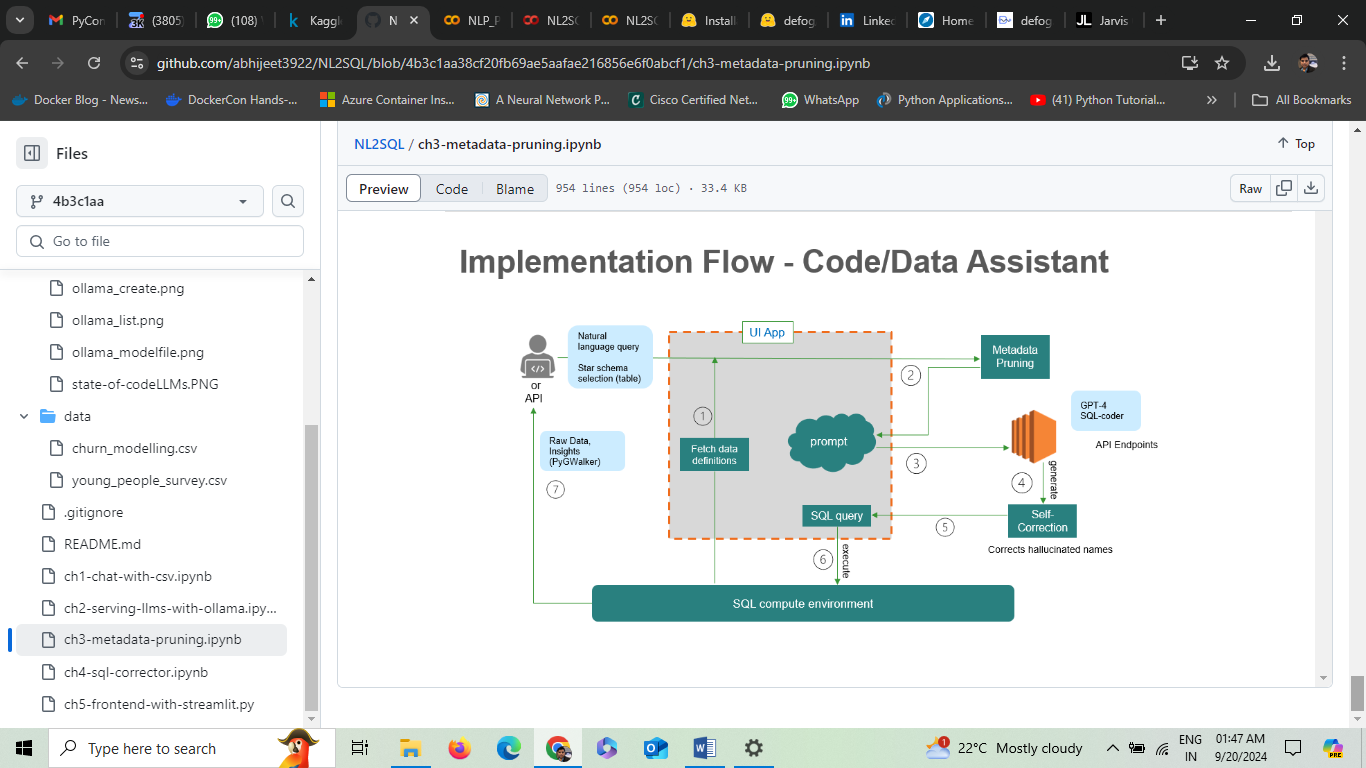